In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import matplotlib.pyplot as plt
import npc_sessions

In [11]:
from npc_sessions import utils
import numpy as np
import rich

In [2]:
session = npc_sessions.Session(
    R'\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-08-03_09-39-59_670248'
    )

# Sync

In [23]:
devices = utils.get_ephys_timing_on_pxi(session.ephys_recording_dirs)
for device in devices:
        (
            ephys_barcode_times,
            ephys_barcode_ids,
        ) = utils.extract_barcodes_from_times(
            on_times=device.ttl_sample_numbers[device.ttl_states > 0]
            / device.sampling_rate,
            off_times=device.ttl_sample_numbers[device.ttl_states < 0]
            / device.sampling_rate,
        )
        plt.plot(np.diff(ephys_barcode_times))

### barcodes

In [105]:
full_exp_recording_dirs = [utils.get_single_oebin_path(directory).parent for directory in session.ephys_record_node_dirs]
display(tuple((device.name, device.sampling_rate, device.start_time) for device in npc_sessions.get_ephys_timing_on_sync(session.sync_path, full_exp_recording_dirs)))

(('Neuropix-PXI-100.ProbeA-AP', 30000.07066388302, 0.7318752524919077),
 ('Neuropix-PXI-100.ProbeA-LFP', 2500.0057470175457, 0.7318752519092182),
 ('Neuropix-PXI-100.ProbeB-AP', 30000.06513994748, 0.7318977347268153),
 ('Neuropix-PXI-100.ProbeB-LFP', 2500.0053220994273, 0.7318977342897848),
 ('Neuropix-PXI-100.ProbeC-AP', 30000.270375398457, 0.7319038945408243),
 ('Neuropix-PXI-100.ProbeC-LFP', 2500.022531283205, 0.7319034261214324),
 ('NI-DAQmx-105.PXI-6133', 30029.953880364792, 0.732419971292545),
 ('Neuropix-PXI-100.ProbeD-AP', 30000.117192416932, 0.731152965792593),
 ('Neuropix-PXI-100.ProbeD-LFP', 2500.009783739666, 0.7311501553492075),
 ('Neuropix-PXI-100.ProbeE-AP', 30000.22087243772, 0.7311548749790954),
 ('Neuropix-PXI-100.ProbeE-LFP', 2500.018494561085, 0.7311501911491055),
 ('Neuropix-PXI-100.ProbeF-AP', 30000.081711754083, 0.7311506115442034),
 ('Neuropix-PXI-100.ProbeF-LFP', 2500.0068093128407, 0.7311501431248528))

get barcode intervals for each probe

In [83]:
barcode_rising = session.sync_data.get_rising_edges(0, 'seconds')
barcode_falling = session.sync_data.get_falling_edges(0, 'seconds')
barcode_times, barcodes = utils.extract_barcodes_from_times(barcode_rising, barcode_falling)

devices_pxi = utils.get_ephys_timing_on_pxi(full_exp_recording_dirs)
devices_sync = tuple(utils.get_ephys_timing_on_sync(session.sync_path, session.ephys_recording_dirs))
device_barcode_dict = {}
for device in devices_pxi:
        if 'NI-DAQmx' in device.name or 'LFP' in device.name:
            continue
        
        device_sync = [d for d in devices_sync if d.name==device.name][0]

        (
            ephys_barcode_times,
            ephys_barcode_ids,
        ) = utils.extract_barcodes_from_times(
            on_times=device.ttl_sample_numbers[device.ttl_states > 0]
            / device.sampling_rate,
            off_times=device.ttl_sample_numbers[device.ttl_states < 0]
            / device.sampling_rate,
        )
        raw = ephys_barcode_times
        corrected = ephys_barcode_times*(30000/device_sync.sampling_rate)
        intervals = np.diff(corrected)
        max_deviation = np.max(np.abs(intervals - np.median(intervals)))

        device_barcode_dict[device.name] = {'barcode_times_raw': raw, 
                                            'barcode_times_corrected': corrected,
                                            'max_deviation_from_median_interval': max_deviation}

sync:  max_deviation = 7.000000015011665e-05

Neuropix-PXI-100.ProbeA-AP:  max_deviation = 6.666650955367004e-05

Neuropix-PXI-100.ProbeB-AP:  max_deviation = 9.999978259145337e-05

Neuropix-PXI-100.ProbeC-AP:  max_deviation = 6.666606600447267e-05

Neuropix-PXI-100.ProbeD-AP:  max_deviation = 6.666640649655164e-05

Neuropix-PXI-100.ProbeE-AP:  max_deviation = 9.999926334103293e-05

Neuropix-PXI-100.ProbeF-AP:  max_deviation = 6.666648511099993e-05

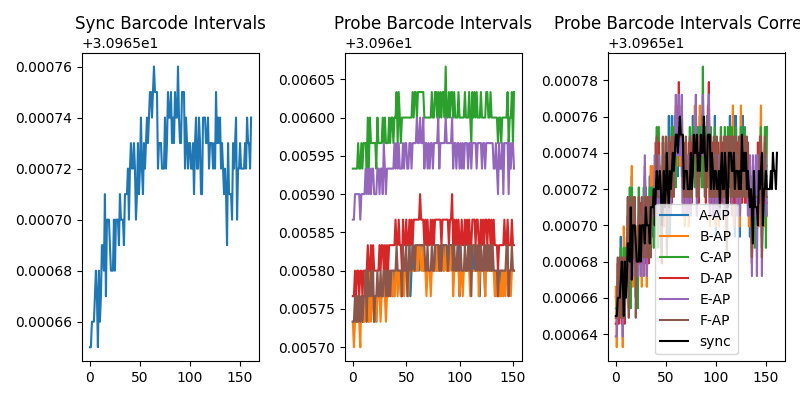

In [108]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches([8, 4])
sync_intervals = np.diff(barcode_times)
sync_max_deviation_from_median_interval = np.max(np.abs(sync_intervals - np.median(sync_intervals)))
start_tag, end_tag = ('[bold green]', '[/bold green]') if sync_max_deviation_from_median_interval<0.001 else ('[bold magenta]', '[/bold magenta]')
rich.print(start_tag + 'sync:  max_deviation = ' + str(sync_max_deviation_from_median_interval) + end_tag)

ax[0].plot(sync_intervals)
legend = []
for device_name, device_data in device_barcode_dict.items():
    ax[1].plot(np.diff(device_data['barcode_times_raw']))
    ax[2].plot(np.diff(device_data['barcode_times_corrected']))
    legend.append(device_name.split('Probe')[1])
    max_deviation = device_data['max_deviation_from_median_interval']
    start_tag, end_tag = ('[bold green]', '[/bold green]') if max_deviation<0.001 else ('[bold magenta]', '[/bold magenta]')
    rich.print(start_tag + device_name + ':  max_deviation = ' + str(max_deviation) + end_tag)



ax[2].plot(sync_intervals, 'k')
ax[2].legend(legend + ['sync'])
ax[0].set_title('Sync Barcode Intervals')
ax[1].set_title('Probe Barcode Intervals')
ax[2].set_title('Probe Barcode Intervals Corrected')

plt.tight_layout()

## stim frame intervals

In [ ]:
rich.print('[bold] Fraction long frames [/bold]')
for stim_name, stim_times in stim_display_times.items():
    intervals = np.diff(stim_times)
    fraction_long = np.sum(intervals>0.02)/len(intervals)
    longest_interval = max(intervals)
    start_tag, end_tag = ('[bold green]', '[/bold green]') if fraction_long<0.01 and longest_interval<0.5 else ('[bold magenta]', '[/bold magenta]')
    rich.print(start_tag + stim_name.stem.split('_')[0] + ': ' + str(fraction_long) + ' \t\t longest interval:' + str(longest_interval) + end_tag)
    

 Fraction long frames 

RFMapping: 0.004460894126814064                  longest interval:0.05009559581642975

SpontaneousRewards: 2.7778549404150115e-05               longest interval:0.020273740006132357

DynamicRouting1: 0.004587449801670403            longest interval:0.19957173815282658

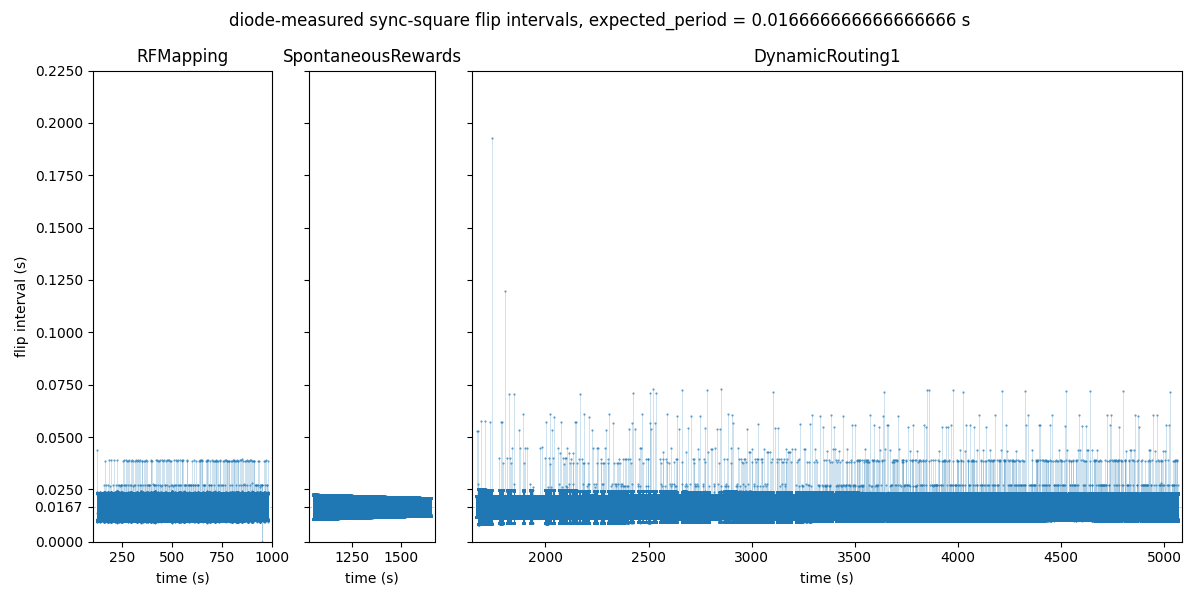

In [118]:
fig, axes = session.sync_data.plot_diode_measured_sync_square_flips()
stim_display_times = npc_sessions.get_stim_frame_times(*session.stim_paths, sync=session.sync_data)
names = tuple(k for k, v in stim_display_times.items() if v is not None)
for idx, ax in enumerate(axes):
    ax.set_title(names[idx].stem.split('_')[0])
fig.set_size_inches(12, 6)

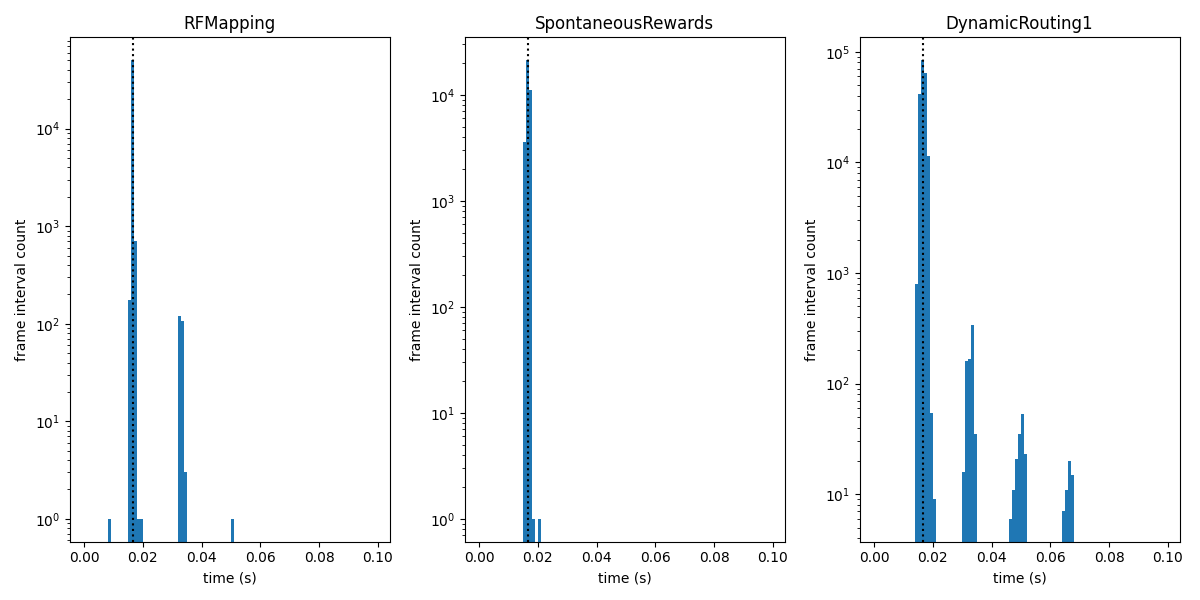

In [132]:
fig_hist, axes_hist = plt.subplots(1, len(axes))
fig_hist.set_size_inches(12, 6)

for ax, (stim_name, stim_times) in zip(axes_hist, stim_display_times.items()):
    ax.hist(np.diff(stim_times), bins=np.arange(0, 0.1, 0.001))
    ax.set_yscale('log')
    ax.axvline(1/60, c='k', ls='dotted')
    ax.set_title(stim_name.stem.split('_')[0])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('frame interval count')
plt.tight_layout()

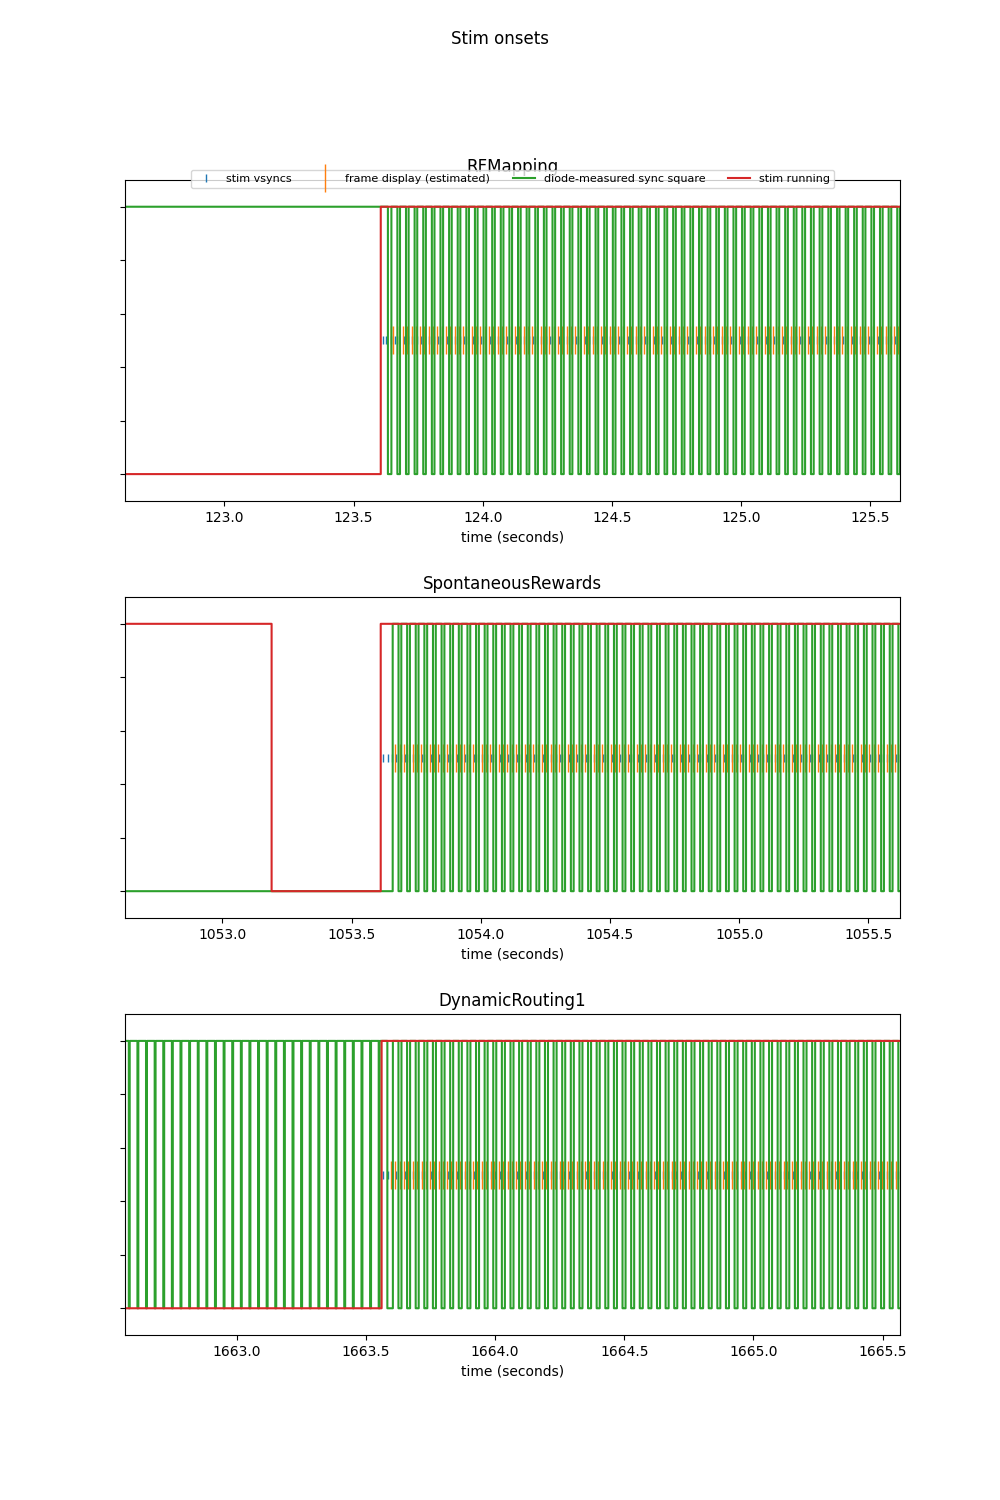

In [110]:
fig, axes = session.sync_data.plot_stim_onsets()
names = tuple(k for k, v in stim_display_times.items() if v is not None)
for idx, ax in enumerate(axes):
    ax.set_title(names[idx].stem.split('_')[0])
fig.set_size_inches(10, 5 * len(axes))
fig.subplots_adjust(hspace=0.3)


# MVR

In [ ]:
import IPython.display

for info in session.video_info_data.values():
    print(info['CameraLabel']), display(IPython.display.JSON(
        {
            k:v
            for k,v in info.items() 
            if k in ('FPS', 'Duration', 'FramesRecorded', 'FramesLostCount')
        } | {'Lost': f"{100 * info['FramesLostCount'] / info['FramesRecorded']:.5f}%"}
    )
)

In [ ]:
from typing import Iterable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import datetime
import io

import upath

def camera_frame_grabs_simple(
    paths: Iterable[upath.UPath],
    num_frames_to_grab: int = 5,
) -> None:
    """Just plots evenly spaced frames, no concept of epochs.
    
    video frames across cameras aren't synced .
    """
    fig = plt.figure(figsize=[20, 3 * len(paths)], constrained_layout=True, facecolor='0.5')
    gs = gridspec.GridSpec(len(paths), num_frames_to_grab, figure=fig)
    gs.update(wspace=0.0, hspace=0.0)
    for idx, video_path in enumerate(paths):
        # get frames to plot
        v = cv2.VideoCapture(video_path.as_posix()) # TODO open with upath from cloud
        
        frame_delta = np.ceil(v.get(7) / num_frames_to_grab + 1)
        frames_of_interest = np.arange(v.get(5), v.get(7), frame_delta)

        for i, f in enumerate(frames_of_interest):
            v.set(cv2.CAP_PROP_POS_FRAMES, int(f))
            ret, frame = v.read()
            ax = fig.add_subplot(gs[idx, i])
            ax.imshow(frame)
            # ax.axis('off')
            ax.tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
            )
            ax.set_title(datetime.timedelta(seconds=f/v.get(5)), fontsize=10)
    return fig

fig = camera_frame_grabs_simple(session.video_paths)

## Verify frame times can be found on sync

In [ ]:
npc_sessions.get_video_frame_times(session.sync_data, *session.video_paths)